In [1]:
import os
import sys
import numpy as np

import umap.umap_ as umap

%load_ext autoreload
%autoreload 2

import xfmreadout.processops as processops
import xfmreadout.clustering as clustering
import xfmreadout.visualisations as vis
import xfmreadout.structures as structures
import xfmreadout.entry_processed

#add the parent folder to sys path so we can import from the notebook subfolder
sys.path.insert(0,'..')


BASEDIR = ""
TIFDIR = "/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo_short"
#TIFDIR = "/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/NC_s4r2"
EXT='.tiff'

image_directory = os.path.join(BASEDIR, TIFDIR)
output_directory = os.path.join(image_directory, "outputs")

if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
#image_directory = ALLDIR




/home/lachlan/.pyenv/versions/3.10.6/envs/venv_xfmread/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lachlan/.pyenv/versions/3.10.6/envs/venv_xfmread/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lachlan/.pyenv/versions/

-----------------
BEGIN reading processed data
Location: /home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo_short
-----
Map files found: 20
Elements identified: ['Al', 'As', 'Ca', 'Cl', 'Compton', 'Cr', 'Cu', 'Fe', 'K', 'Mn', 'Mo', 'MoL', 'Ni', 'P', 'S', 'Si', 'Ti', 'V', 'Zn', 'sum']
-----------------
READING MAP DATA
Initial shape: (393, 700, 20)
Revised shape: (392, 700, 20)
-----
-----------------
READING VARIANCE DATA
Initial shape: (197, 350, 20)
Revised shape: (197, 350, 20)
-----
averaging channel 3, cycle 0 -- dataq99: 13301.299, sdq2: 9435.495, ratio: 2.819
averaging channel 3, cycle 1 -- dataq99: 5948.521, sdq2: 7333.275, ratio: 1.622
averaging channel 4, cycle 0 -- dataq99: 0.002, sdq2: 0.001, ratio: 3.198
averaging channel 4, cycle 1 -- dataq99: 0.001, sdq2: 0.001, ratio: 2.278
averaging channel 4, cycle 2 -- dataq99: 0.000, sdq2: 0.001, ratio: 1.176
averaging channel 5, cycle 0 -- dataq99: 3304.713, sdq2: 2727.802, ratio: 2.423
averaging channel 5, cycle 1 -- da

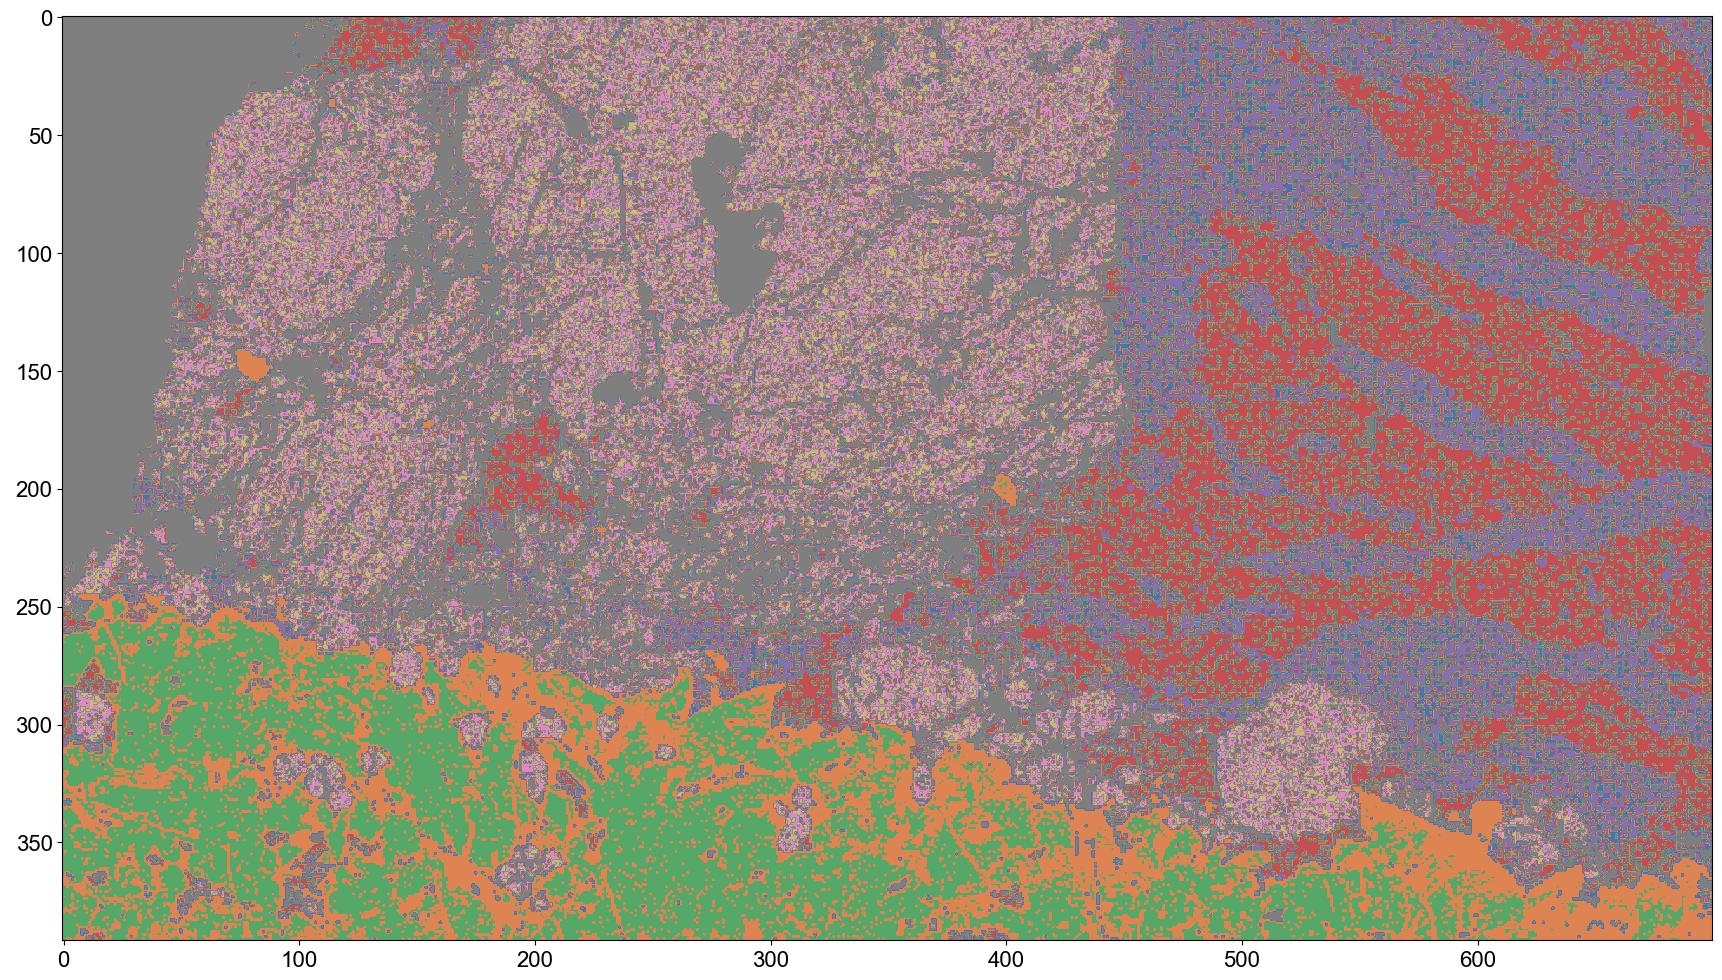

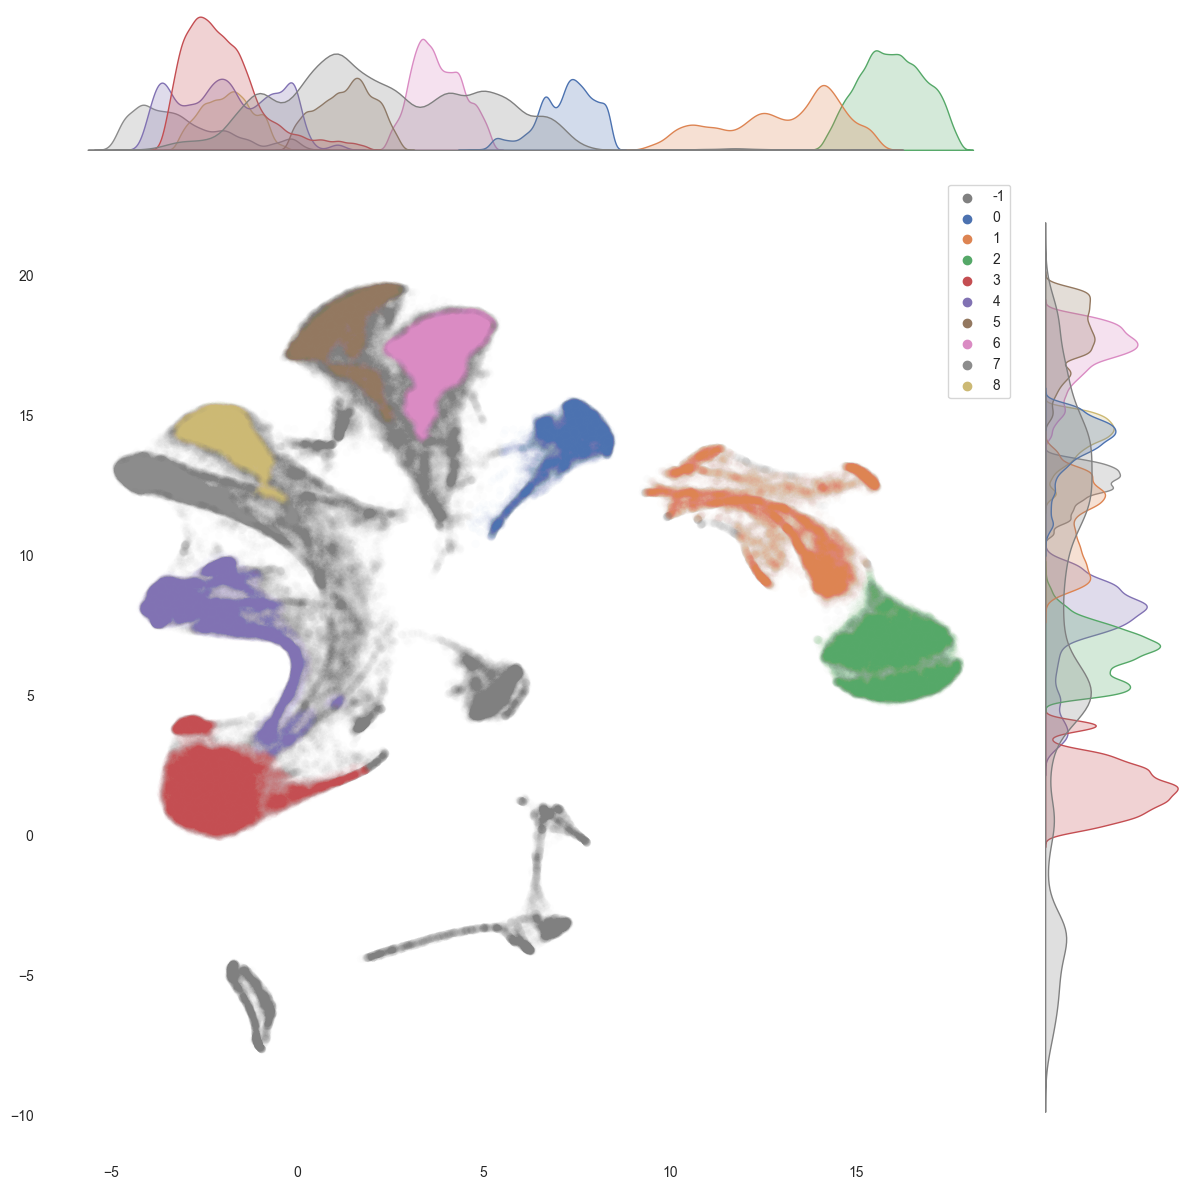

+----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+-----------+-------------+-------------+-------------+-------------+-----------+
|    |          Al |          As |          Ca |          Cl |     Compton |          Cr |          Cu |          Fe |           K |          Mn |         Mo |         MoL |          Ni |           P |         S |          Si |          Ti |           V |          Zn |       sum |
|----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+-----------+-------------+-------------+-------------+-------------+-----------|
|  0 | 0.00287684  | 0.00021559  | 0.0414211   | 5.29232e-06 | 0.00113052  | 2.73386e-05 | 0.0874483   | 0.585619    | 0.000544847 | 0.00596523  | 0.07766

In [2]:
#args = ' -d /home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo_short -n 2'
args = ["-d", "/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo_short", "-n", "2",]

pxs, embedding, categories, classavg, palette = xfmreadout.entry_processed.read_processed(args)

In [3]:
from sklearn.neighbors import KernelDensity
import xfmreadout.visualisations as vis

kde = KernelDensity(kernel='gaussian')

kde.fit(embedding)


KernelDensity()

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ex = embedding[:,0]
ey = embedding[:,1]

x = np.linspace(np.min(ex), np.max(ex), 100)
y = np.linspace(np.min(ex), np.max(ex), 100)

X, Y = np.meshgrid(x, y)

xy = np.vstack([Y.ravel(), X.ravel()]).T

xy.shape

Z = kde.score_samples(xy)



Text(0.5, 0, 'Z axis')

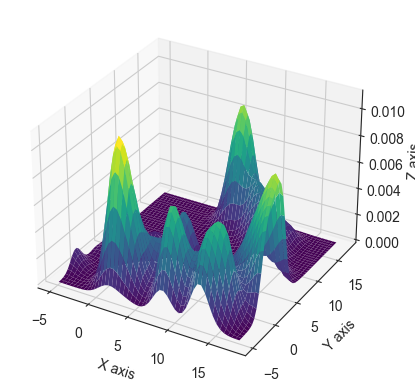

In [44]:
Z_work = np.exp(Z)
Z_work = Z_work.reshape(X.shape)

#Make a 3D plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z_work,cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')